Detail main har ek variable ka scaling and all kara and
1. got many variables after transformation with increased correlation

2. due to smote many categorical variables had been changed to a continuous distribution which I categorised again

3. there were some repetitive columns so removed them

4. Trained model with the selected variables which resulted in Decrease in result drastically


So now we have feature extraction for all variables with increased correlation however that can't be used as model input as it drastically decreases the results on baseline model

# Imports

In [1]:
import numpy as np
import pandas as po
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd drive/MyDrive/Open\ IIT\ DA\ 2021/

/content/drive/.shortcut-targets-by-id/1FmqUtHqXjOsF1btGtFibwcKqHS_R0EkZ/Open IIT DA 2021


In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Preprocessing Function

In [6]:
pop_dict = {'very low': 1, 'low': 2, 'average': 3, 'high': 4, 'very high': 5}
mode_dict = {'Minor': 1, 'Major': 2}
explicit_dict = {'No': 1, 'Yes': 2}

In [7]:
def revenue(Y_test, Y_pred):
  revenue = 10000
  i = 0
  while i < len(Y_test) and revenue >= 0:
    if Y_test[i] <= Y_pred[i]:
      revenue += Y_test[i]*2 - Y_pred[i]
    i += 1
  return revenue 

In [8]:
po.options.mode.chained_assignment = None  # default='warn'

## Functions for new features

In [9]:
def get_year_band(data):
    year_band = []
    for i in range(len(data)):
        value = 0
        if data.iloc[i]["year"]<=2030:
          value = 1
        if data.iloc[i]["year"]<=2010:
          value = 2
        if data.iloc[i]["year"]<=2000:
          value = 3
        if data.iloc[i]["year"]<=1980:
          value = 4
        if data.iloc[i]["year"]<=1970:
          value = 5
        if data.iloc[i]["year"]<=1960:
          value = 6
        if data.iloc[i]["year"]<=1950:
          value = 7
        if data.iloc[i]["year"]<=1940:
          value = 8
        if data.iloc[i]["year"]<=1930:
          value = 9
        
        year_band.append(value)
    
    return year_band

In [10]:
def get_month_band(data):
    month_band = []
    for i in range(len(data)):
        value = 0
        if data.iloc[i]['month']<=12:
          value = 1
        if data.iloc[i]['month']<=10:
          value = 2
        if data.iloc[i]['month']<=8:
          value = 3
        if data.iloc[i]['month']<=7:
          value = 4
        if data.iloc[i]['month']<=5:
          value = 5
        if data.iloc[i]['month']<=4:
          value = 6
        if data.iloc[i]['month']<=3:
          value = 7
        if data.iloc[i]['month']<=2:
          value = 8
        
        month_band.append(value)
    
    return month_band

In [11]:
def transform_loudness(data):
    data2=data.copy()
    
    x="loudness"
    bins=[]
    bins.append(data2[x].min()-1)
    bins.append(data2[x].mean()-3.5*data2[x].std())
    bins.append(data2[x].mean()-3*data2[x].std())
    bins.append(data2[x].mean()-2.5*data2[x].std())
    bins.append(data2[x].mean()-2*data2[x].std())
    bins.append(data2[x].mean()-1.5*data2[x].std())
    bins.append(data2[x].mean()-1*data2[x].std())
    bins.append(data2[x].mean()-0.5*data2[x].std())
    bins.append(data2[x].mean())
    bins.append(data2[x].mean()+0.5*data2[x].std())
    bins.append(data2[x].mean()+1.5*data2[x].std())
    bins.append(data2[x].max())

    labels = [1,2,3,4,5,6,7,8,9,10,11]
    data2["loudness"]=po.cut(data2["loudness"], bins=bins, labels=labels).astype('int')

    return data2["loudness"]

## Main Preprocess Function

In [12]:
def preprocess(data):

  # Label Encode Features
  if "popularity" in data:
    data["popularity"] = data["popularity"].apply(lambda x: pop_dict[x])

  data["mode"] = data["mode"].apply(lambda x: mode_dict[x])
  data["explicit"] = data["explicit"].apply(lambda x: explicit_dict[x])

  # Add new features
  data["day_of_week"] = data["release_date"].apply(lambda x: datetime.strptime(x, "%d-%m-%Y").weekday())
  data["day_of_month"] = data["release_date"].apply(lambda x: datetime.strptime(x, "%d-%m-%Y").day)
  data["week_of_year"] = data["release_date"].apply(lambda x: datetime.strptime(x, "%d-%m-%Y").isocalendar()[1])
  data["month"] = data["release_date"].apply(lambda x: datetime.strptime(x, "%d-%m-%Y").month)
  data["year"] = data["release_date"].apply(lambda x: datetime.strptime(x, "%d-%m-%Y").year)
  data["is_weekend"] = data["day_of_week"].apply(lambda x: 1 if x>=5 else 0)
  data["year_band"] = get_year_band(data)
  data["month_band"] = get_month_band(data)
  data["loudness"] = transform_loudness(data)

  data = data.drop(["release_date", "id"], axis=1)

  return data

In [13]:
df_train = preprocess(po.read_csv('Dataset/Train_data.csv').sample(frac=1, random_state=69).reset_index(drop=True))

In [15]:
df_train.head(3)

,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,year,duration-min,popularity,day_of_week,day_of_month,week_of_year,month,is_weekend,year_band,month_band
0,0.0578,0.601,0.677,1,0.004780,10,0.0721,9,1,0.1290,136.421,0.790,1985,3.7,2,1,1,1,1,0,3,8
1,0.0118,0.561,0.964,2,0.000004,1,0.8750,10,2,0.5220,160.088,0.452,2020,2.0,4,4,26,26,6,0,1,4
2,0.3120,0.651,0.691,1,0.000000,0,0.2330,10,2,0.0706,147.049,0.661,2018,4.2,1,4,23,47,11,0,1,1


In [16]:
X = df_train.drop(['popularity'], axis=1)
y = df_train['popularity']

In [18]:
from imblearn.over_sampling import SVMSMOTE
oversample = SVMSMOTE()
X, y = oversample.fit_resample(X, y)

In [19]:
cols = list(df_train.columns)
cols.remove("popularity")

In [20]:
df_train = po.DataFrame(X, columns=cols)
df_train['popularity'] = y

## Test on SOTA model 

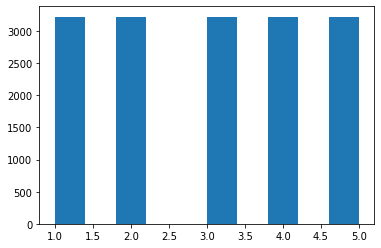

In [21]:
plt.hist(y)
plt.show()

In [22]:
score = make_scorer(revenue, greater_is_better=True)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=4000/len(X), random_state=69)

In [24]:
clf = RandomForestClassifier(random_state=69, n_jobs=-1)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=69, verbose=0,
                       warm_start=False)

In [25]:
clf = RandomForestClassifier(random_state=69, n_jobs=-1)
gs = GridSearchCV(clf, param_grid={'n_estimators': [200], "max_features": ["auto"]}, scoring=score, verbose=1, cv=3, n_jobs=-1)
gs = gs.fit(X_train,y_train) 
clf = gs.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.4s finished


In [26]:
gs.best_params_

{'max_features': 'auto', 'n_estimators': 200}

In [27]:
clf.feature_importances_

array([0.06135892, 0.04773835, 0.05301628, 0.01529495, 0.04693419,
       0.02942975, 0.04296484, 0.03753463, 0.01152385, 0.04663983,
       0.04413818, 0.04181321, 0.21165116, 0.04581311, 0.02703099,
       0.03810162, 0.03225226, 0.02710658, 0.00467803, 0.11731197,
       0.01766729])

In [28]:
y_pred = clf.predict(X_test)

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.86      0.82      0.84       800
           2       0.58      0.66      0.62       825
           3       0.52      0.51      0.52       774
           4       0.70      0.65      0.67       764
           5       0.94      0.94      0.94       837

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000



In [30]:
print(f1_score(y_test,y_pred,average='weighted')*100)
print(revenue(y_test, y_pred))

72.0369357841223
19246


In [32]:
df_train.head(2)

,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,year,duration-min,day_of_week,day_of_month,week_of_year,month,is_weekend,year_band,month_band,popularity
0,0.0578,0.601,0.677,1.0,0.004780,10.0,0.0721,9.0,1.0,0.129,136.421,0.790,1985.0,3.7,1.0,1.0,1.0,1.0,0.0,3.0,8.0,2
1,0.0118,0.561,0.964,2.0,0.000004,1.0,0.8750,10.0,2.0,0.522,160.088,0.452,2020.0,2.0,4.0,26.0,26.0,6.0,0.0,1.0,4.0,4


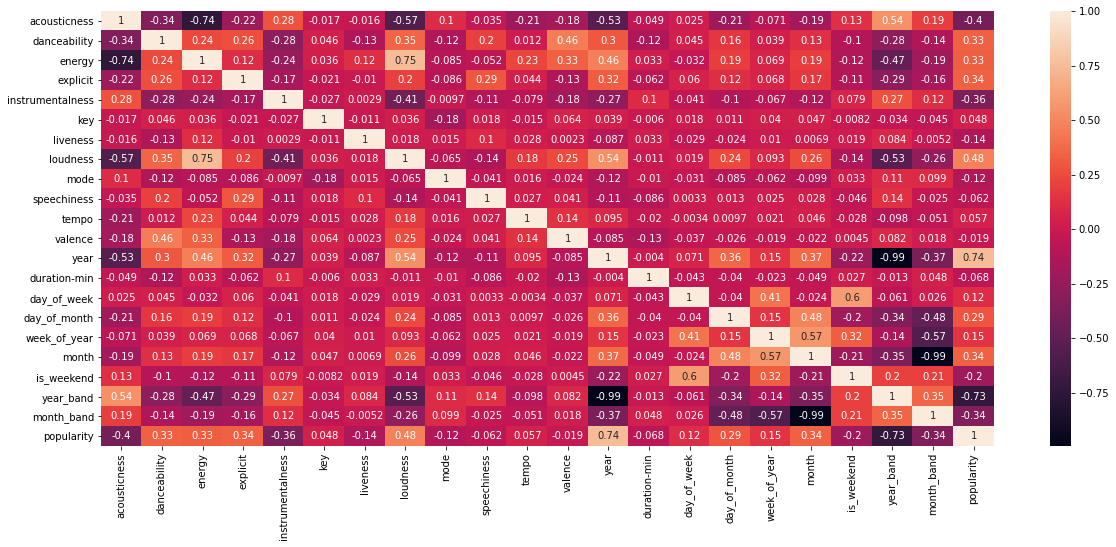

In [40]:
plt.figure(figsize=(20,8))
sns.heatmap(df_train.corr(),annot=True)
plt.show()

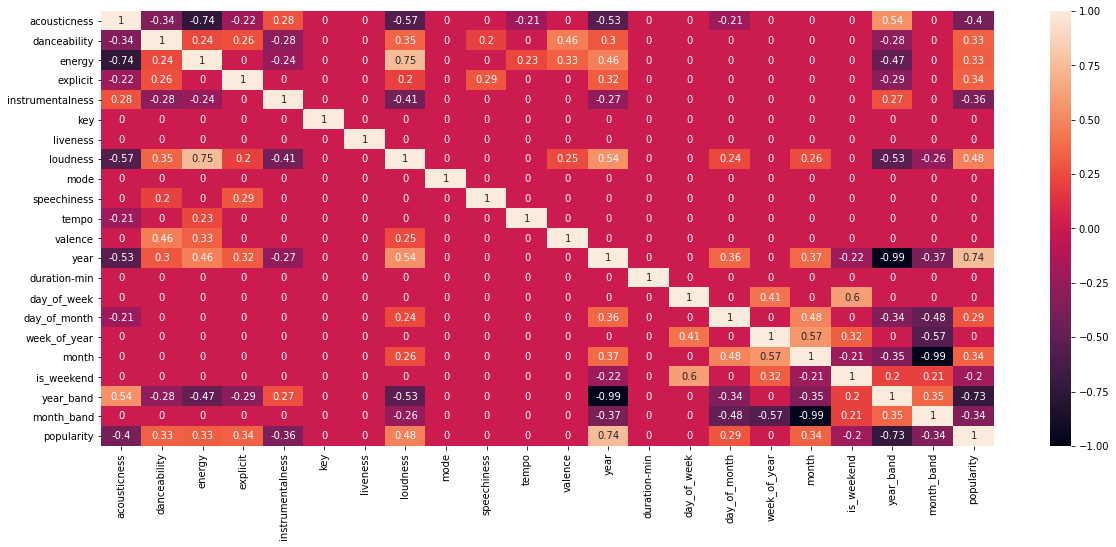

In [42]:
plt.figure(figsize=(20,8))
subjective_corr = df_train.corr()
subjective_corr[np.abs(subjective_corr)<.2 ] = 0
sns.heatmap(subjective_corr,vmin=-1,vmax=1,annot=True)

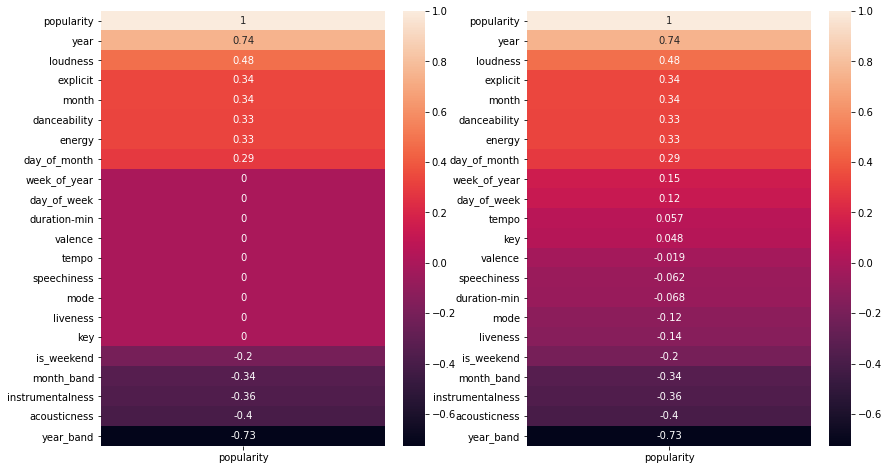

In [50]:
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
sns.heatmap(subjective_corr[['popularity']].sort_values(by=['popularity'],ascending=False),annot=True)
plt.subplot(1,2,2)

sns.heatmap(df_train.corr()[['popularity']].sort_values(by=['popularity'],ascending=False),annot=True)



#testing

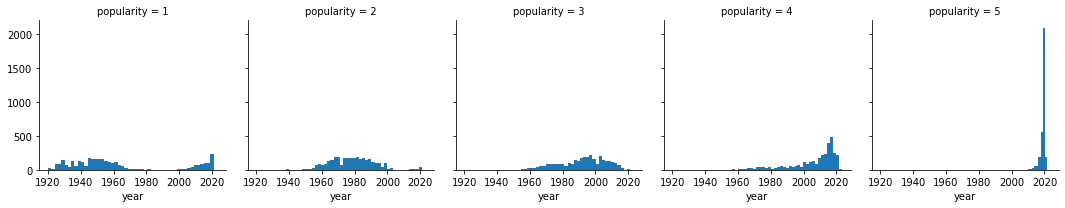

In [51]:
g=sns.FacetGrid(df_train, col='popularity')
g=g.map(plt.hist,'year',bins=50)

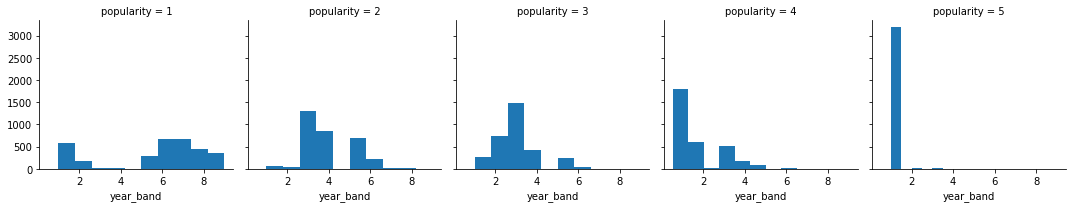

In [53]:
g=sns.FacetGrid(df_train, col='popularity')
g=g.map(plt.hist,'year_band')

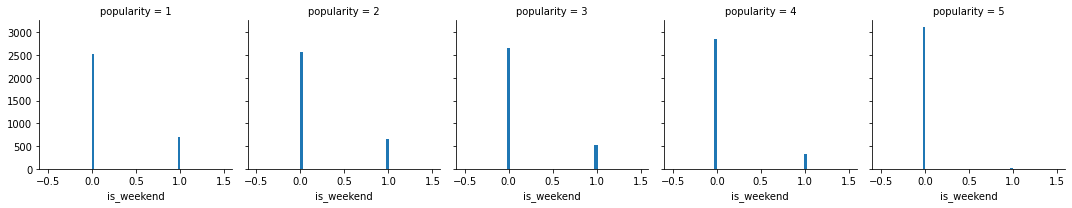

In [54]:
g=sns.FacetGrid(df_train, col='popularity')
g=g.map(plt.hist,'is_weekend',bins=50)

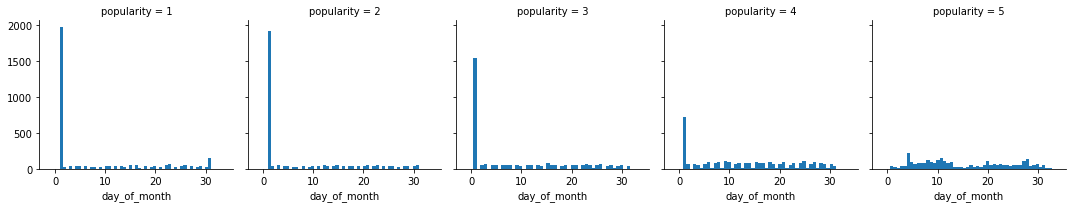

In [55]:
g=sns.FacetGrid(df_train, col='popularity')
g=g.map(plt.hist,'day_of_month',bins=50)

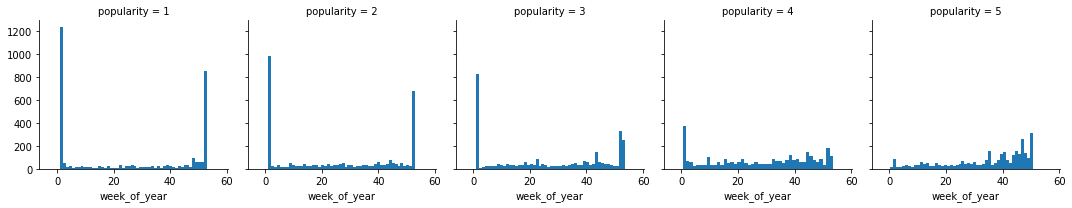

In [57]:
g=sns.FacetGrid(df_train, col='popularity')
g=g.map(plt.hist,'week_of_year',bins=50)

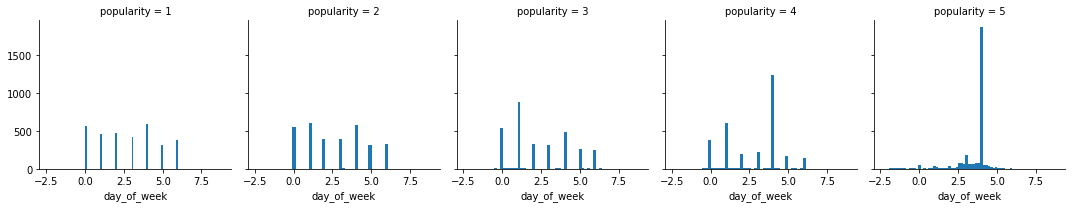

In [56]:
g=sns.FacetGrid(df_train, col='popularity')
g=g.map(plt.hist,'day_of_week',bins=50)

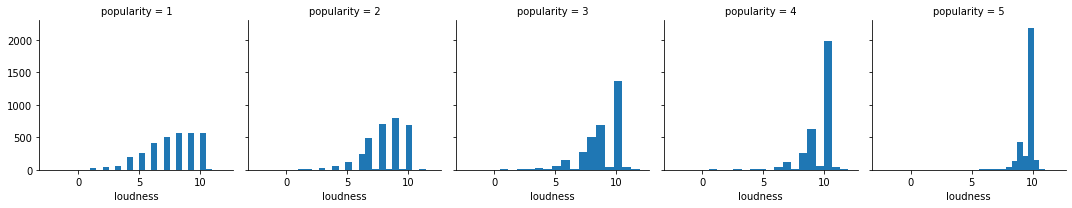

In [60]:
g=sns.FacetGrid(df_train, col='popularity')
g=g.map(plt.hist,'loudness',bins=20)

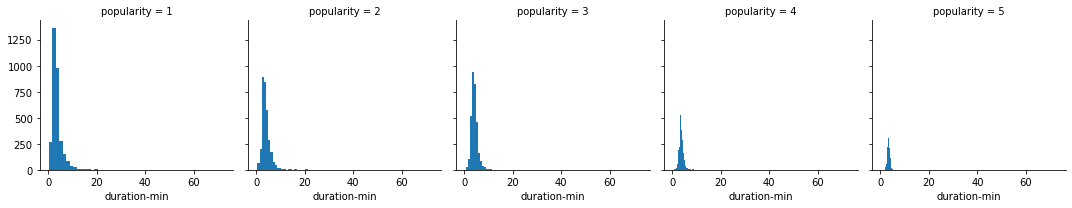

In [62]:
g=sns.FacetGrid(df_train, col='popularity')
g=g.map(plt.hist,'duration-min',bins=50)

In [70]:
df2['duration-min']=np.log(df2['duration-min']+1)

In [71]:
print(df2.corr().loc['popularity','duration-min'])
print(df_train.corr().loc['popularity','duration-min'])

0.006985462338538207
-0.06801756896295666


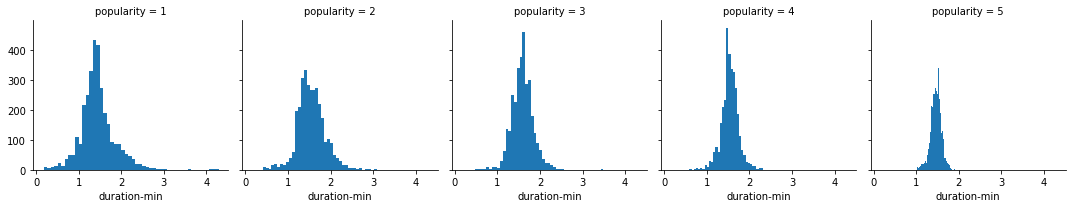

In [72]:
g=sns.FacetGrid(df2, col='popularity')
g=g.map(plt.hist,'duration-min',bins=50)

In [73]:
df2=df2.drop(columns=['year_band','month_band'])
df2.shape

(16110, 20)

In [75]:
X = df2.drop(['popularity'], axis=1)
y = df2['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=4000/len(X), random_state=69)
clf = RandomForestClassifier(random_state=69, n_jobs=-1)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=69, verbose=0,
                       warm_start=False)

In [80]:
clf = RandomForestClassifier(random_state=69, n_jobs=-1)
gs = GridSearchCV(clf, param_grid={'n_estimators': [200], "max_features": ["auto"]}, scoring=score, verbose=1, cv=3, n_jobs=-1)
gs = gs.fit(X_train,y_train.to_numpy()) 
clf = gs.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.3s finished


In [82]:
y_pred = clf.predict(X_test)

print(f1_score(y_test,y_pred,average='weighted')*100)
print(revenue(y_test.to_numpy(), y_pred))

71.97302751220633
19309


In [95]:
df2['speechiness']=np.exp(df_train['speechiness'])

In [96]:
print(df2.corr().loc['popularity','speechiness'])
print(df_train.corr().loc['popularity','speechiness'])

-0.09829317512644363
-0.06222736767618614


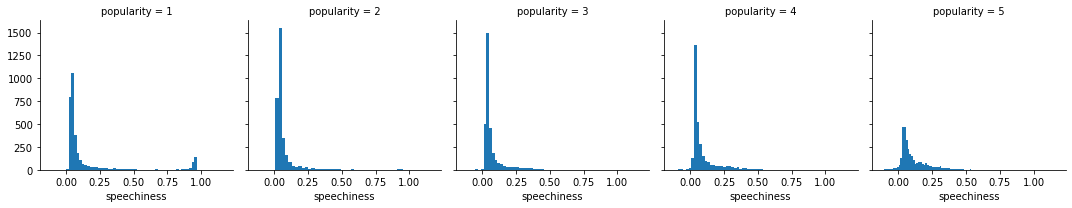

In [85]:
g=sns.FacetGrid(df_train, col='popularity')
g=g.map(plt.hist,'speechiness',bins=50)

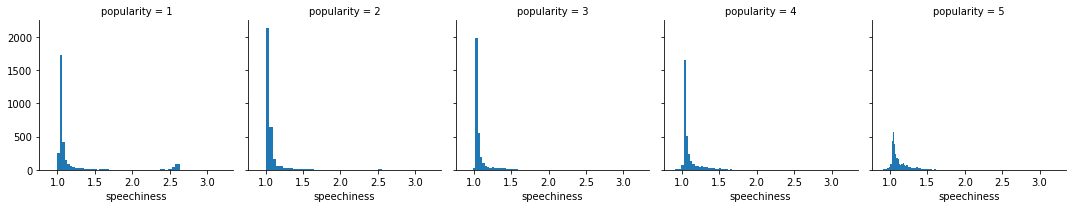

In [86]:
g=sns.FacetGrid(df2, col='popularity')
g=g.map(plt.hist,'speechiness',bins=50)

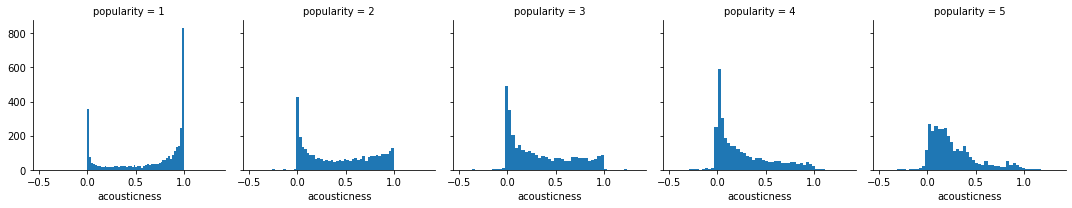

In [97]:
g=sns.FacetGrid(df_train, col='popularity')
g=g.map(plt.hist,'acousticness',bins=50)

-0.41972211142981114
-0.397135810619363


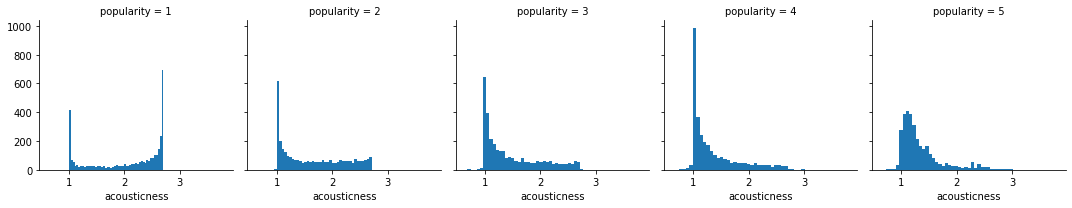

In [101]:
df2['acousticness']=np.exp(df_train.acousticness)
print(df2.corr().loc['popularity','acousticness'])
print(df_train.corr().loc['popularity','acousticness'])
g=sns.FacetGrid(df2, col='popularity')
g=g.map(plt.hist,'acousticness',bins=50)

In [117]:
print(df_train.shape)
df_train.columns

(16110, 22)


Index(['acousticness', 'danceability', 'energy', 'explicit',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence', 'year', 'duration-min',
       'day_of_week', 'day_of_month', 'week_of_year', 'month', 'is_weekend',
       'year_band', 'month_band', 'popularity'],
      dtype='object')

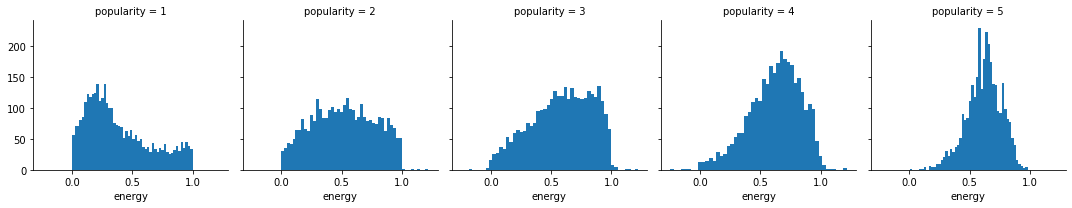

In [118]:
g=sns.FacetGrid(df_train, col='popularity')
g=g.map(plt.hist,'energy',bins=50)

0.3471451854502842
0.3268805999872224


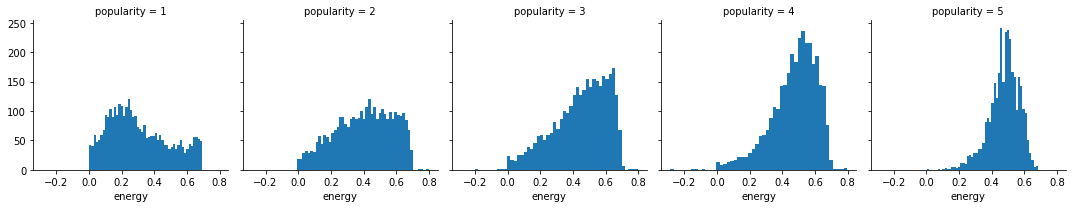

In [120]:
df2['energy']=np.log(df_train.energy+1)

print(df2.corr().loc['popularity','energy'])
print(df_train.corr().loc['popularity','energy'])
g=sns.FacetGrid(df2, col='popularity')
g=g.map(plt.hist,'energy',bins=50)

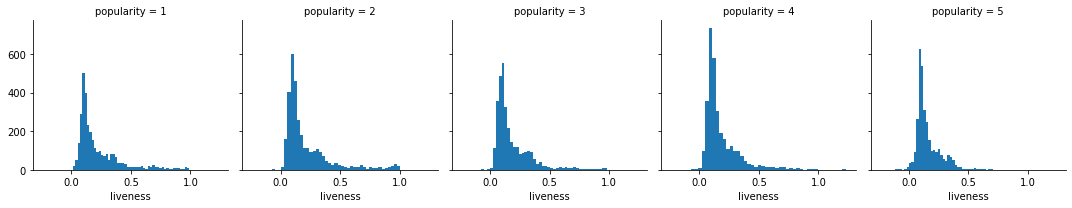

In [123]:
g=sns.FacetGrid(df_train, col='popularity')
g=g.map(plt.hist,'liveness',bins=50)

-0.13640099766994593
-0.13709830799770684


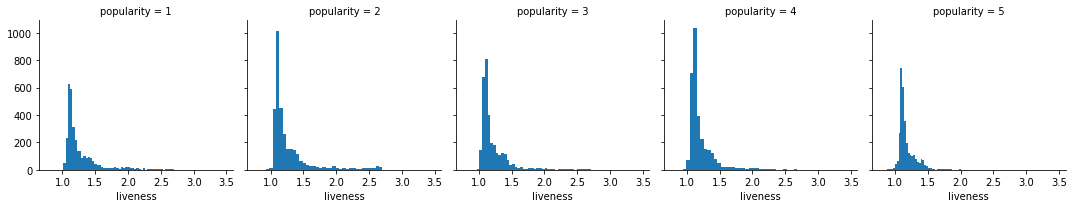

In [125]:
df2['liveness']=np.exp(df_train.liveness)
print(df2.corr().loc['popularity','liveness'])
print(df_train.corr().loc['popularity','liveness'])
g=sns.FacetGrid(df2, col='popularity')
g=g.map(plt.hist,'liveness',bins=50)

In [131]:
df2['liveness']=df_train['liveness'].copy()

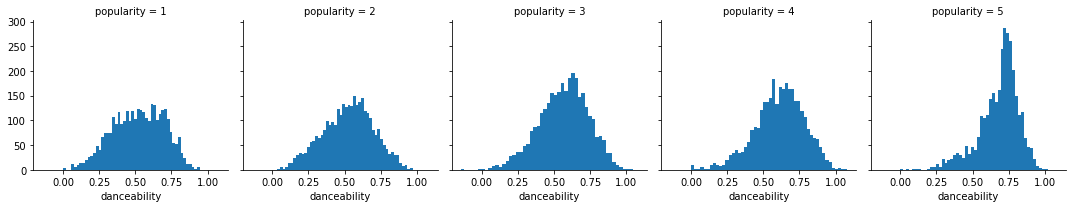

In [126]:
g=sns.FacetGrid(df_train, col='popularity')
g=g.map(plt.hist,'danceability',bins=50)

0.33361846474814494
0.3304437554884216


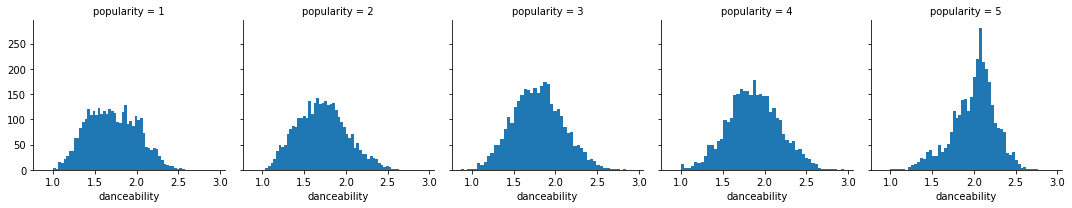

In [130]:
df2['danceability']=np.exp(df_train.danceability)
print(df2.corr().loc['popularity','danceability'])
print(df_train.corr().loc['popularity','danceability'])
g=sns.FacetGrid(df2, col='popularity')
g=g.map(plt.hist,'danceability',bins=50)

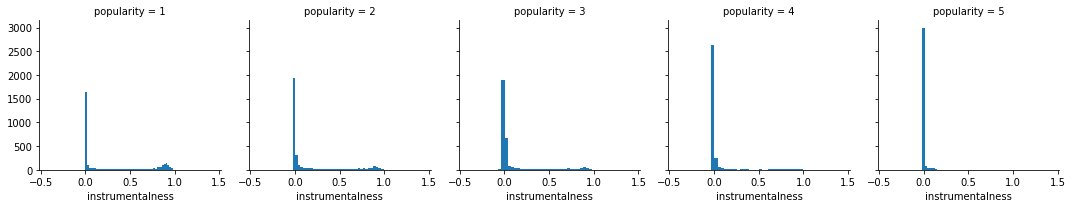

In [133]:
g=sns.FacetGrid(df_train, col='popularity')
g=g.map(plt.hist,'instrumentalness',bins=50)

-0.3689547152047655
-0.3631374139483297


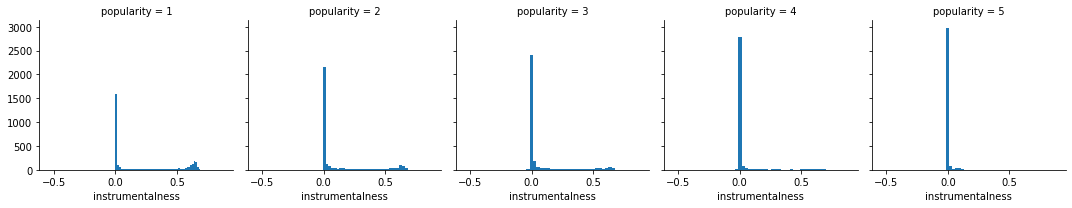

In [136]:
df2['instrumentalness']=np.log(df_train.instrumentalness+1)
print(df2.corr().loc['popularity','instrumentalness'])
print(df_train.corr().loc['popularity','instrumentalness'])
g=sns.FacetGrid(df2, col='popularity')
g=g.map(plt.hist,'instrumentalness',bins=50)

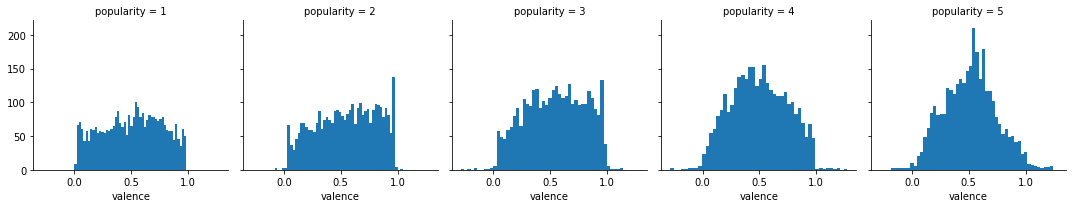

In [170]:
g=sns.FacetGrid(df_train, col='popularity')
g=g.map(plt.hist,'valence',bins=50)

-0.030230208939409742
-0.019499053376674385


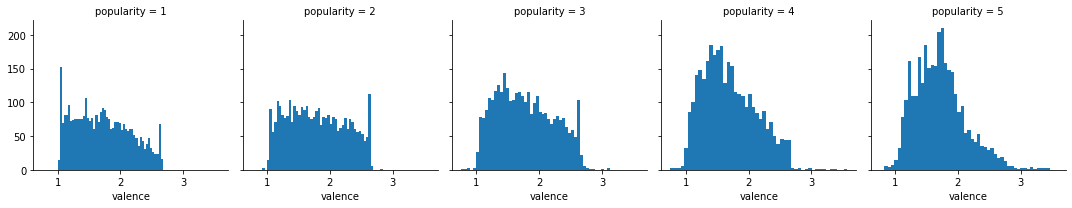

In [173]:
df2['valence']=np.exp(df_train.valence)
print(df2.corr().loc['popularity','valence'])
print(df_train.corr().loc['popularity','valence'])
g=sns.FacetGrid(df2, col='popularity')
g=g.map(plt.hist,'valence',bins=50)

In [174]:
X = df2.drop(['popularity'], axis=1)
y = df2['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=4000/len(X), random_state=69)
clf = RandomForestClassifier(random_state=69, n_jobs=-1)
clf.fit(X_train,y_train)
clf = RandomForestClassifier(random_state=69, n_jobs=-1)
gs = GridSearchCV(clf, param_grid={'n_estimators': [200], "max_features": ["auto"]}, scoring=score, verbose=1, cv=3, n_jobs=-1)
gs = gs.fit(X_train,y_train.to_numpy()) 
clf = gs.best_estimator_
y_pred = clf.predict(X_test)

print(f1_score(y_test,y_pred,average='weighted')*100)
print(revenue(y_test.to_numpy(), y_pred))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.9s finished


71.65235402412154
19259


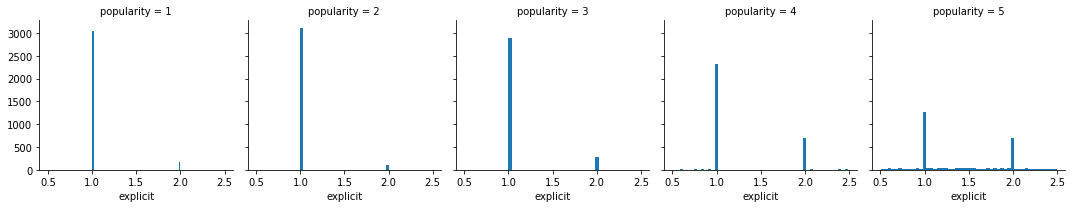

In [147]:
g=sns.FacetGrid(df_train, col='popularity')
g=g.map(plt.hist,'explicit',bins=50)

0.34736471590747886
0.33753469374953193


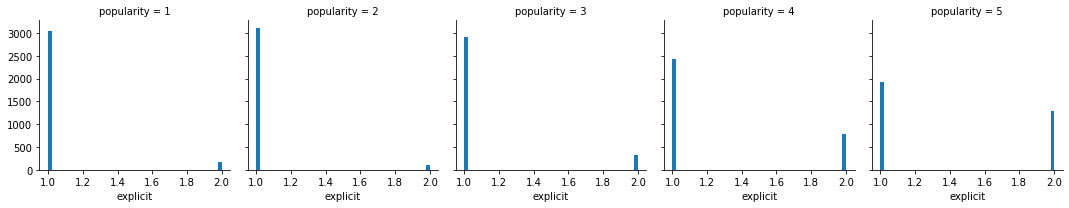

In [150]:
df2.loc[df2['explicit']>1.5,'explicit']=2
df2.loc[df2['explicit']<=1.5,'explicit']=1
print(df2.corr().loc['popularity','explicit'])
print(df_train.corr().loc['popularity','explicit'])
g=sns.FacetGrid(df2, col='popularity')
g=g.map(plt.hist,'explicit',bins=50)

In [151]:
X = df2.drop(['popularity'], axis=1)
y = df2['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=4000/len(X), random_state=69)
clf = RandomForestClassifier(random_state=69, n_jobs=-1)
clf.fit(X_train,y_train)
clf = RandomForestClassifier(random_state=69, n_jobs=-1)
gs = GridSearchCV(clf, param_grid={'n_estimators': [200], "max_features": ["auto"]}, scoring=score, verbose=1, cv=3, n_jobs=-1)
gs = gs.fit(X_train,y_train.to_numpy()) 
clf = gs.best_estimator_
y_pred = clf.predict(X_test)

print(f1_score(y_test,y_pred,average='weighted')*100)
print(revenue(y_test.to_numpy(), y_pred))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.8s finished


71.45466969955582
19258


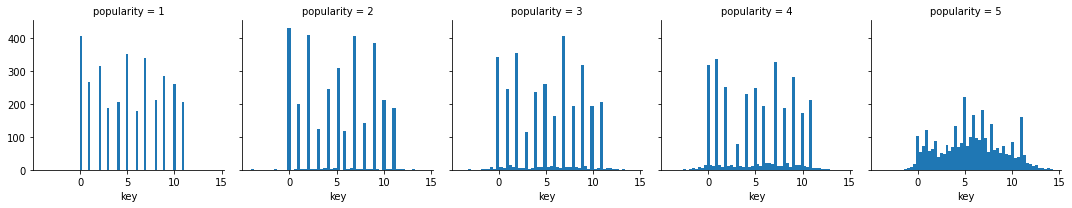

In [152]:
g=sns.FacetGrid(df_train, col='popularity')
g=g.map(plt.hist,'key',bins=50)

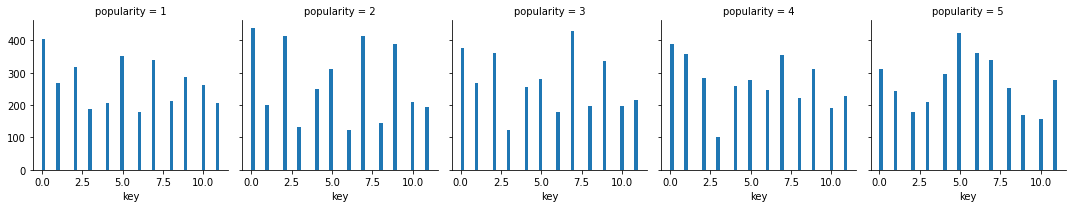

In [165]:
df2['key']=df2['key'].astype(int)
df2.loc[df2['key']<=0,'key']=0
df2.loc[df2['key']>=11,'key']=11
g=sns.FacetGrid(df2, col='popularity')
g=g.map(plt.hist,'key',bins=50)

In [166]:
print(df2.corr().loc['popularity','key'])
print(df_train.corr().loc['popularity','key'])

0.016414111467751034
0.047837189038453104


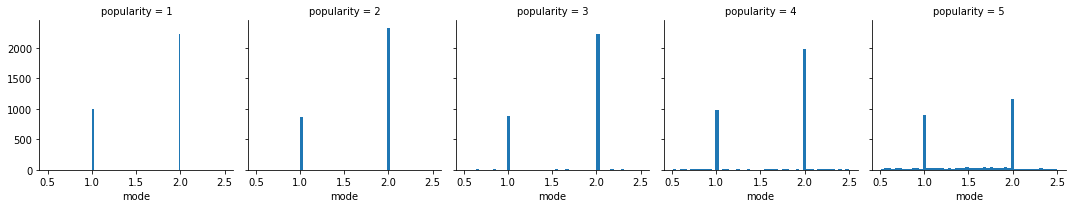

In [167]:
g=sns.FacetGrid(df_train, col='popularity')
g=g.map(plt.hist,'mode',bins=50)

-0.11068280022435356
-0.11517395413362667


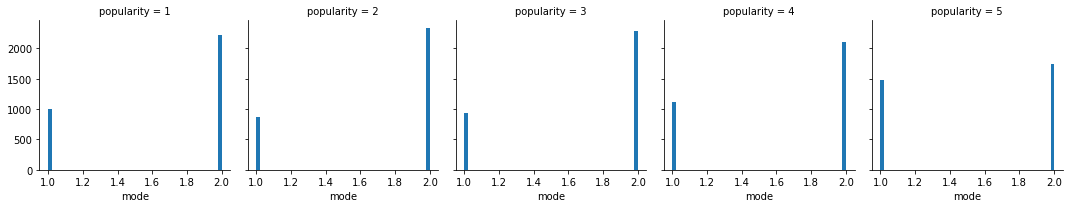

In [169]:
df2.loc[df2['mode']>1.5,'mode']=2
df2.loc[df2['mode']<=1.5,'mode']=1
print(df2.corr().loc['popularity','mode'])
print(df_train.corr().loc['popularity','mode'])
g=sns.FacetGrid(df2, col='popularity')
g=g.map(plt.hist,'mode',bins=50)

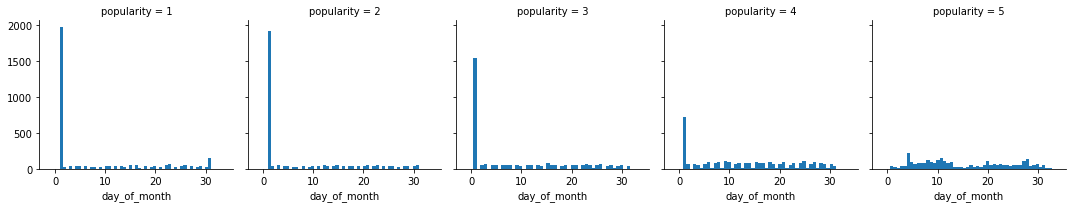

In [175]:
g=sns.FacetGrid(df_train, col='popularity')
g=g.map(plt.hist,'day_of_month',bins=50)

In [200]:
df2['year']=df2['year'].astype('int')
df2['is_weekend']=df2['is_weekend'].astype('int')
df2['day_of_month']=df2['day_of_month'].astype('int')
df2['day_of_week']=df2['day_of_week'].astype('int')
df2['month']=df2['month'].astype('int')
df2['week_of_year']=df2['week_of_year'].astype('int')
df2.loc[df2['year']<0,'year']=0
df2.loc[df2['is_weekend']<0,'is_weekend']=0
df2.loc[df2['day_of_month']<0,'day_of_month']=0
df2.loc[df2['day_of_week']<0,'day_of_week']=0
df2.loc[df2['month']<0,'month']=0
df2.loc[df2['week_of_year']<0,'week_of_year']=0

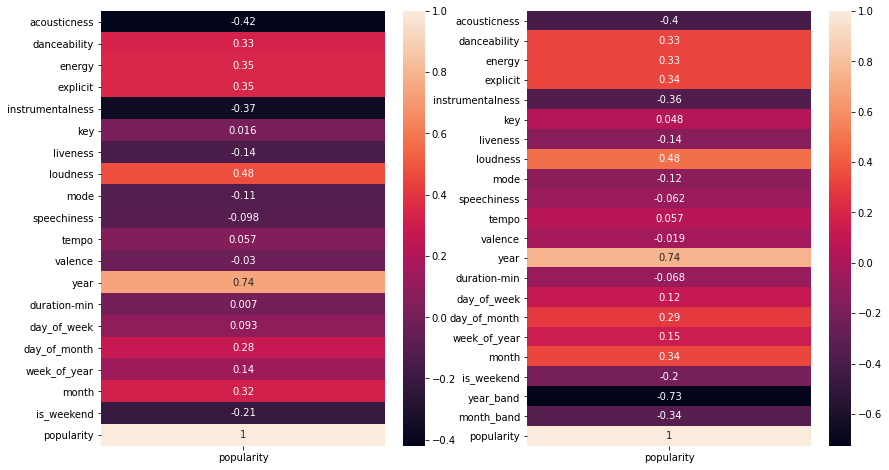

In [202]:
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
sns.heatmap(df2.corr()[['popularity']],annot=True)
plt.subplot(1,2,2)

sns.heatmap(df_train.corr()[['popularity']],annot=True)

#final selected

In [261]:
df2=df_train.copy()
df2['year']=df2['year'].astype('int')
df2['is_weekend']=df2['is_weekend'].astype('int')
df2['day_of_month']=df2['day_of_month'].astype('int')
df2['month']=df2['month'].astype('int')
df2.loc[df2['year']<0,'year']=0
df2.loc[df2['is_weekend']<0,'is_weekend']=0
df2.loc[df2['day_of_month']<0,'day_of_month']=0
df2.loc[df2['month']<0,'month']=0
df2.loc[df2['explicit']>1.5,'explicit']=2
df2.loc[df2['explicit']<=1.5,'explicit']=1
df2=df2.drop(columns=['year_band','month_band','week_of_year','day_of_week','duration-min','speechiness','key','tempo','valence','liveness','mode'])
df2['energy']=np.log(df_train.energy+1)
df2['danceability']=np.exp(df_train.danceability)
df2['instrumentalness']=np.log(df_train.instrumentalness+1)
df2['acousticness']=np.exp(df_train.acousticness)


In [262]:
df2.shape

(16110, 11)

In [263]:
df2.columns

Index(['acousticness', 'danceability', 'energy', 'explicit',
       'instrumentalness', 'loudness', 'year', 'day_of_month', 'month',
       'is_weekend', 'popularity'],
      dtype='object')

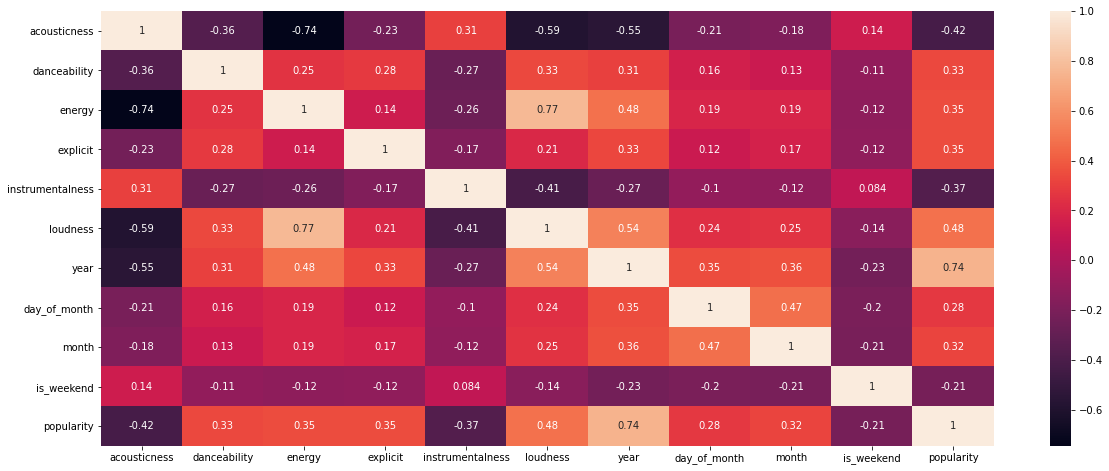

In [264]:
plt.figure(figsize=(20,8))
sns.heatmap(df2.corr(),annot=True)
plt.show()

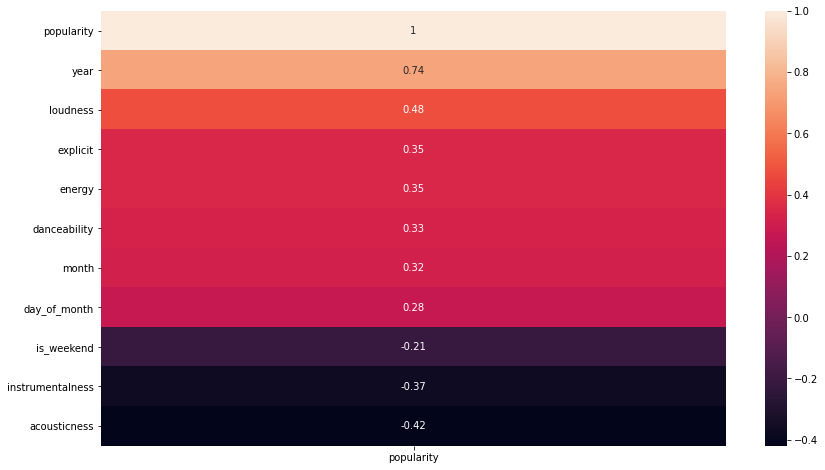

In [265]:
plt.figure(figsize=(14,8))
sns.heatmap(df2.corr()[['popularity']].sort_values(by=['popularity'],ascending=False),annot=True)

In [266]:
X = df2.drop(['popularity'], axis=1)
y = df2['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=4000/len(X), random_state=69)

clf = RandomForestClassifier(random_state=69, n_jobs=-1)
gs = GridSearchCV(clf, param_grid={'n_estimators': [200], "max_features": ["auto"]}, scoring=score, verbose=1, cv=3, n_jobs=-1)
gs = gs.fit(X_train,y_train.to_numpy()) 
clf = gs.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.7s finished


In [267]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.82      0.83       800
           2       0.58      0.63      0.60       825
           3       0.50      0.48      0.49       774
           4       0.65      0.59      0.62       764
           5       0.90      0.94      0.92       837

    accuracy                           0.69      4000
   macro avg       0.69      0.69      0.69      4000
weighted avg       0.69      0.69      0.69      4000



In [268]:
print(f1_score(y_test,y_pred,average='weighted')*100)
print(revenue(y_test.to_numpy(), y_pred))

69.3767905847555
19120
